**Trabalho Modelo Linear Generalizado**

Gustavo Mario Detile (NUSP 11931653)

Gabriel Ferri Pires de Carvalho (NUSP 11218427)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.genmod.families import links
import math
from sklearn.feature_selection import chi2
import scipy.stats as stat
from scipy.stats import norm
from scipy.special import logit
from matplotlib import pyplot as plt
import statsmodels.api as sm
import plotly.express as px


Entrada dos Dados

In [53]:
dose = [10.2, 7.7, 5.1, 3.8, 2.6, 0.0]
m = [50, 49, 46, 48, 50, 49]
y = [44, 42, 24, 16, 6, 0]

#### y2 == m-n

dados = pd.DataFrame({'dose': [10.2, 7.7, 5.1, 3.8, 2.6, 0.0],'y': [44, 42, 24, 16, 6, 0], 'y2':[6,7,22,32,44,49]})

Gráfico de Dispersão

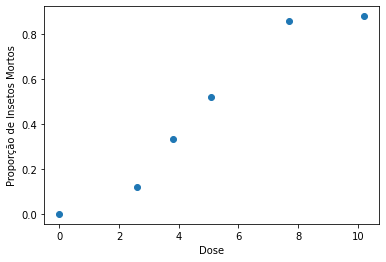

In [54]:
pmortos = []
for i in range(0,6):
  pmortos.append(round(float(y[i]/m[i]),7))



plt.scatter(dose,pmortos)
plt.xlabel("Dose")
plt.ylabel("Proporção de Insetos Mortos")
plt.show()
  

Modelo Binomial

In [60]:
## Ligação canonica (default)

sucs = dados[['y','y2']]
faill = sm.add_constant(dados.dose)
modelo1 = sm.GLM(sucs,faill,sm.families.Binomial()).fit()
print(modelo1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            ['y', 'y2']   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14.739
Date:                Wed, 28 Sep 2022   Deviance:                       10.258
Time:                        23:55:25   Pearson chi2:                     9.70
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2257      0.370     -8.720      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Teste de Hipótese

In [56]:
chi_scores = stat.chi2.cdf(modelo1.deviance,df=modelo1.df_resid)
print("p-valor: ",round((1-chi_scores), 3))

p-valor:  0.036


*não rejeitamos a hipótese de que o modelo faz um bom ajuste aos dados (1% sig.)*


 Sobreponha a curva ajustada ao gráfico da figura à pag. 1.

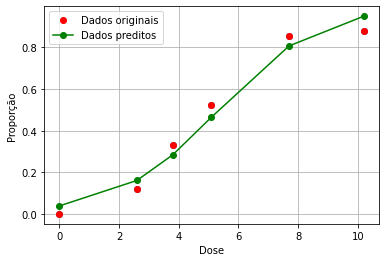

,0,1
const,-3.951,-2.501
x1,0.472,0.738


In [57]:

plt.scatter(dose,pmortos)
y_pred = modelo1.predict()
plt.plot(dose,pmortos, 'ro', label='Dados originais')
plt.plot(dose,y_pred, 'go-', label = 'Dados preditos')
plt.ylabel("Proporção")
plt.xlabel("Dose")
plt.grid()
plt.legend()
plt.show(True)

## Intervalos de confiança assintóticos
# x1 = 'Dose', 0 = '2,5%', 1 = '97,5%'
round(modelo1.conf_int(),3)


Razão de Chances

In [70]:
modelo1.params
print("Razão de Chances =", round(math.exp(modelo1.params['dose']),3))

##  IC para Razão de Chances

VALUES1 = modelo1.conf_int().values
print ("Intervalo de Confiança:")
print(round(math.exp(VALUES1[1,0]),5),round(math.exp(VALUES1[1,1]),5))


Razão de Chances = 1.831
Intervalo de Confiança:
1.60354 2.09182


Dose Letal

In [79]:
def DL(prob):
 return((math.log(prob / (1 - prob)) - modelo1.params[0]) / modelo1.params[1])
print("DL50 e DL90 = ",DL(0.5), DL(0.9))

## Intervalo de Confiança
cov = np.array(modelo1.normalized_cov_params)

def IC(prob):
 b = np.array([[-1/modelo1.params[1]],
 [(np.log(prob / (1 - prob)) - modelo1.params[0]) / (modelo1.params[1]*modelo1.params[1])]])
 p = b.transpose() @ cov @ b
 return 'Inferior', DL(prob) - 1.96*math.sqrt(p) , 'Superior' , DL(prob)+ 1.96*math.sqrt(p)

print('IC DL50', IC(0.5))
print('IC DL90', IC(0.9))

DL50 e DL90 =  5.3305686438715 8.961591258619604
IC DL50 ('Inferior', 3.0195101436148786, 'Superior', 7.641627144128121)
IC DL90 ('Inferior', 5.867876049715679, 'Superior', 12.055306467523529)


Inversa das funções de ligação

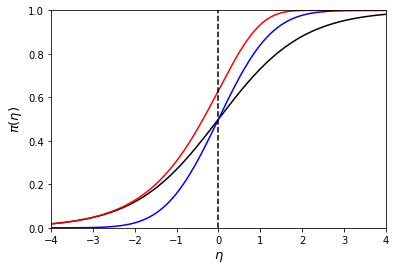

In [81]:
def abline(slope, intercept):
 axes = plt.gca()
 x_vals = np.array(axes.get_xlim())
 y_vals = intercept + slope * x_vals
 plt.plot(x_vals, y_vals, '--')

def plogis(x):
 x = float(x)
 return 1 / (1 + math.exp(-x))

plogis1 = np.vectorize(plogis)

# Clog-log
def ploglog(x):
 x = float(x)
 return (1 - math.exp(-math.exp(x)))
ploglog1 = np.vectorize(ploglog)

x = np.arange(-4, 4.01, 0.01)
plt.plot(x, plogis1(x), color="black")
plt.plot(x, norm.cdf(x), color="blue") 
plt.plot(x, ploglog1(x), color="red")
plt.ylim(0, 1)
plt.xlim(-4, 4)
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\pi(\eta)$', fontsize=13)
plt.axvline(x = 0, color = 'black', linestyle='--')
plt.show()


Ajustes

In [91]:
## Probito

sucs = dados[['y','y2']]
faill = sm.add_constant(dados['dose'])
modelo1_probit = sm.GLM(sucs,faill,family=sm.families.Binomial(link = links.probit()))
modelo1_probit_result = modelo1_probit.fit()
print(modelo1_probit_result.summary())

chi_scores = stat.chi2.cdf(modelo1_probit_result.deviance,df=modelo1_probit_result.df_resid)
print("p-valor probito: ",round((1-chi_scores), 5))
print("\n")
## Cloglog

sucs = dados[['y','y2']]
faill = sm.add_constant(dados['dose'])
modelo1_cloglog = sm.GLM(sucs,faill,family=sm.families.Binomial(link = links.cloglog()))
modelo1_cloglog_result = modelo1_cloglog.fit()
print(modelo1_cloglog_result.summary())

chi_scores2 = stat.chi2.cdf(modelo1_cloglog_result.deviance,df=modelo1_cloglog_result.df_resid)
print("p-valor cloglog: ",round((1-chi_scores2), 5))

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ['y', 'y2']   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:                Binomial   Df Model:                            1
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14.938
Date:                Thu, 29 Sep 2022   Deviance:                       10.655
Time:                        00:29:34   Pearson chi2:                     10.4
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8778      0.195     -9.637      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
